In [1]:
%%shell

pip install cython -q
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-n6ii61z7
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-n6ii61z7
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=386282 sha256=7b877685d74858ecbad2db9b2d256843503a009dec8a92e652949b9541da2160
  Stored in directory: /tmp/pip-ephem-wheel-cache-tx6yu78m/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6


In [2]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 346172, done.
remote: Counting objects: 100% (81271/81271), done.
remote: Compressing objects: 100% (1679/1679), done.
remote: Total 346172 (delta 80180), reused 80504 (delta 79546), pack-reused 264901
Receiving objects: 100% (346172/346172), 695.46 MiB | 28.49 MiB/s, done.
Resolving deltas: 100% (319159/319159), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [3]:
!pip install roboflow -q

from roboflow import Roboflow
rf = Roboflow(api_key="Rx0od3Taf35NpfNZkc3D")
project = rf.workspace("proj-pgxao").project("mangonet")
dataset = project.version(2).download("coco")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.5 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to MangoNet-2 in coco:: 100%|██████████| 270/270 [00:00<00:00, 1487.32it/s]


In [2]:
%mkdir MangoNet

%mkdir MangoNet/train
%mkdir MangoNet/test
%mkdir MangoNet/valid

%mkdir MangoNet/train/IMG
%mkdir MangoNet/train/MASKS
%mkdir MangoNet/train/MASKS/mask
%touch MangoNet/train/annotations.json

%mkdir MangoNet/test/IMG
%mkdir MangoNet/test/MASKS
%mkdir MangoNet/test/MASKS/mask
%touch MangoNet/test/annotations.json

%mkdir MangoNet/valid/IMG
%mkdir MangoNet/valid/MASKS
%mkdir MangoNet/valid/MASKS/mask
%touch MangoNet/valid/annotations.json

The syntax of the command is incorrect.


The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
UsageError: Line magic function `%touch` not found.


In [4]:
from google.colab import files
files.download('/content/MangoNet-2/train/_annotations.coco.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import os
import sys
import json
import torch
import datetime
import numpy as np
import skimage.draw
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

def getitem(image_id, data, ROOT_DIR):

        img_name = [image for image in data['images'] if image['id'] == image_id][0]['file_name']
        image_path = os.path.join(ROOT_DIR, img_name)
        image = Image.open(image_path).convert("RGB")
        targets = []
        values = [image_path]
        annotations1 = [annotation for annotation in data['annotations'] if annotation['image_id'] == image_id]
        for annotation in annotations1:
            annotation['masks'] = annotation.pop('segmentation')
            annotation['boxes'] = annotation.pop('bbox')
            annotation['labels'] = annotation.pop('category_id')
        values.append(annotations1)
        return values

def store_data(filename, num_values, ROOT_DIR):
    data2 = {}

    annot = os.path.join(ROOT_DIR, "_annotations.coco.json")
    with open(annot, 'r') as f:
        data = json.load(f)

    for index in range(num_values):
        values = getitem(index, data, ROOT_DIR)
        data2[index] = values

    with open(filename, 'w') as f:
        json.dump(data2, f)

def get_value_by_index(filename, index):
    with open(filename, 'r') as f:
        data = json.load(f)
        img_path, targets = data.get(str(index))
        return targets

In [4]:
num_values = 233
filename = r'D:\TS\MangoDetection\MRCNN\MangoNet\train\annotations.json'
RD = r'D:\TS\MangoDetection\MRCNN\Dataset\train'
store_data(filename, num_values, RD)

num_values = 12
filename = r'D:\TS\MangoDetection\MRCNN\MangoNet\test\annotations.json'
RD = r'D:\TS\MangoDetection\MRCNN\Dataset\test'
store_data(filename, num_values, RD)

num_values = 16
filename = r'D:\TS\MangoDetection\MRCNN\MangoNet\valid\annotations.json'
RD = r'D:\TS\MangoDetection\MRCNN\Dataset\valid'
store_data(filename, num_values, RD)

In [5]:
import os
import json
import shutil
import random
from PIL import Image, ImageDraw

def create_palette(num_segments):
    segment_colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(num_segments)]
    palette = [0, 0, 0] + [color for rgb in segment_colors for color in rgb]
    return palette

def create_combined_mask(segmentations):
    max_width = 640
    max_height = 640
    composite_mask = Image.new('P', (max_width, max_height), 0)
    draw = ImageDraw.Draw(composite_mask)
    palette = create_palette(len(segmentations))
    for i, points in enumerate(segmentations):
        color_index = i + 1
        draw.polygon(points, outline=color_index, fill=color_index)
    composite_mask.putpalette(palette)
    return composite_mask

def create_dataset(annotation_file, ROOT_DIR, NEW_IMG_DIR, NEW_MASK_DIR):

  with open(annotation_file, 'r') as file:
    data = json.load(file)

  for key in data:
      segmentations = []

      img_name = data[key][0]
      new_imgname = f'img_{key}.png'
      image_path = os.path.join(ROOT_DIR, img_name)
      train_img_path = os.path.join(NEW_IMG_DIR, new_imgname)

      info_list = data[key][1]
      for info_dict in info_list:
          segmentation = info_dict['masks']
          if segmentation:
              segmentations.append(segmentation[0])
      if len(segmentations)>0:
          shutil.copy(image_path, train_img_path)
          composite_mask = create_combined_mask(segmentations)
          filename = f'_{key}.png'
          composite_mask.save(NEW_MASK_DIR + filename)

In [ ]:
with open(annotation_file, 'r') as file:
    data = json.load(file)
data[key][0]

In [6]:
annotation_file = r'D:\TS\MangoDetection\MRCNN\MangoNet\train\annotations.json'
ROOT_DIR = r'D:\TS\MangoDetection\MRCNN\Dataset\train'
NEW_IMG_DIR = r'D:\TS\MangoDetection\MRCNN\MangoNet\train\IMG'
NEW_MASK_DIR = r'D:\TS\MangoDetection\MRCNN\MangoNet\train\MASKS\mask'
create_dataset(annotation_file, ROOT_DIR, NEW_IMG_DIR, NEW_MASK_DIR)

annotation_file = r'D:\TS\MangoDetection\MRCNN\MangoNet\test\annotations.json'
ROOT_DIR = r'D:\TS\MangoDetection\MRCNN\Dataset\test'
NEW_IMG_DIR = r'D:\TS\MangoDetection\MRCNN\MangoNet\test\IMG'
NEW_MASK_DIR = r'D:\TS\MangoDetection\MRCNN\MangoNet\test\MASKS\mask'
create_dataset(annotation_file, ROOT_DIR, NEW_IMG_DIR, NEW_MASK_DIR)

annotation_file = r'D:\TS\MangoDetection\MRCNN\MangoNet\valid\annotations.json'
ROOT_DIR = r'D:\TS\MangoDetection\MRCNN\Dataset\valid'
NEW_IMG_DIR = r'D:\TS\MangoDetection\MRCNN\MangoNet\valid\IMG'
NEW_MASK_DIR = r'D:\TS\MangoDetection\MRCNN\MangoNet\valid\MASKS\mask'
create_dataset(annotation_file, ROOT_DIR, NEW_IMG_DIR, NEW_MASK_DIR)

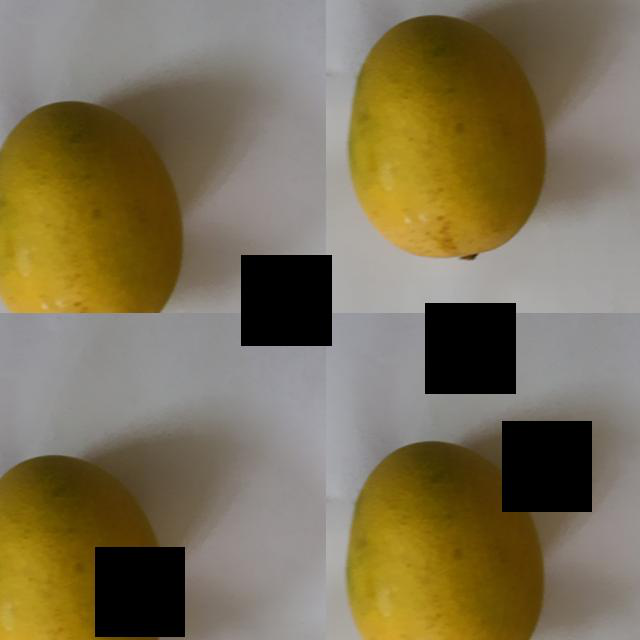

In [18]:
from PIL import Image
Image.open('/content/MangoNet/train/IMG/img_100.png')

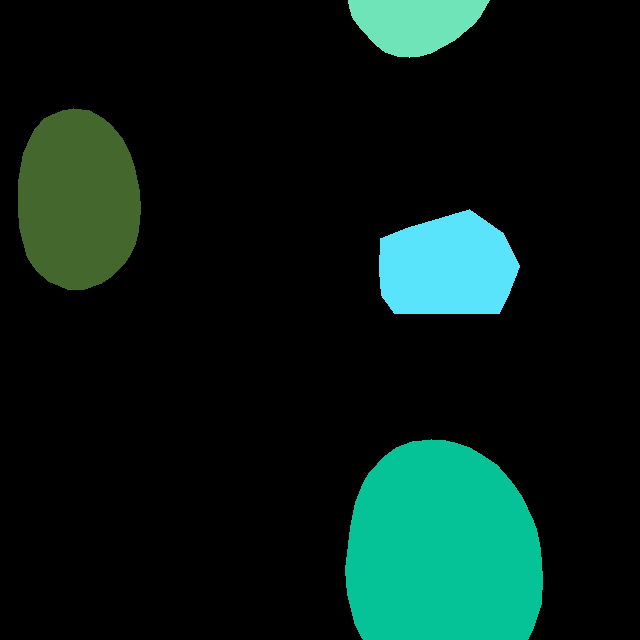

In [19]:
mask = Image.open('/content/MangoNet/train/MASKS/mask_100.png')
mask = mask.convert('P')
mask

In [20]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class MangoDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "IMG"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "MASKS"))))

    def __getitem__(self, idx):
        # load images ad masks
        if idx < 0 or idx >= len(self.imgs):
          raise IndexError("Index&&out&&of range")
        img_path = os.path.join(self.root, "IMG", self.imgs[idx])
        mask_path = os.path.join(self.root, "MASKS", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]        # first id is the background, so remove it
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [21]:
dataset = MangoDataset('/content/MangoNet/train')
len(dataset)

233

In [22]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [23]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [24]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = MangoDataset('/content/MangoNet/train',  get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 325MB/s]
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [25]:
# use our dataset and defined transformations
dataset = MangoDataset('/content/MangoNet/train',  get_transform(train=True))
dataset_test = MangoDataset('/content/MangoNet/valid',  get_transform(train=True))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

In [26]:
torch.cuda.is_available()

True

In [27]:
device = torch.device('cuda')
# if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.1)

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 218MB/s]


In [28]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 100
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    # lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/92]  eta: 0:13:00  lr: 0.000120  loss: 10.2386 (10.2386)  loss_classifier: 0.5743 (0.5743)  loss_box_reg: 0.0136 (0.0136)  loss_mask: 5.1783 (5.1783)  loss_objectness: 3.4272 (3.4272)  loss_rpn_box_reg: 1.0452 (1.0452)  time: 8.4813  data: 0.4935  max mem: 1660
Epoch: [0]  [10/92]  eta: 0:01:31  lr: 0.001218  loss: 2.6096 (4.0819)  loss_classifier: 0.2768 (0.3264)  loss_box_reg: 0.0617 (0.0520)  loss_mask: 1.5195 (2.7867)  loss_objectness: 0.3786 (0.7922)  loss_rpn_box_reg: 0.0330 (0.1246)  time: 1.1099  data: 0.0537  max mem: 1832
Epoch: [0]  [20/92]  eta: 0:00:55  lr: 0.002315  loss: 1.3395 (2.8281)  loss_classifier: 0.1437 (0.2394)  loss_box_reg: 0.0618 (0.0653)  loss_mask: 0.8084 (1.7855)  loss_objectness: 0.2534 (0.6433)  loss_rpn_box_reg: 0.0330 (0.0946)  time: 0.3786  data: 0.0109  max mem: 1833
Epoch: [0]  [30/92]  eta: 0:00:39  lr: 0.003413  loss: 1.0902 (2.3350)  loss_classifier: 0.1379 (0.2088)  loss_box_reg: 0.0804 (0.0730)  loss_mask: 0.5670 (1.3906)  loss_

IsADirectoryError: ignored

In [ ]:
from google.colab import files
files.download('/root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth')

In [ ]:
# pick one image from the test set
img, _ = dataset_test[13]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

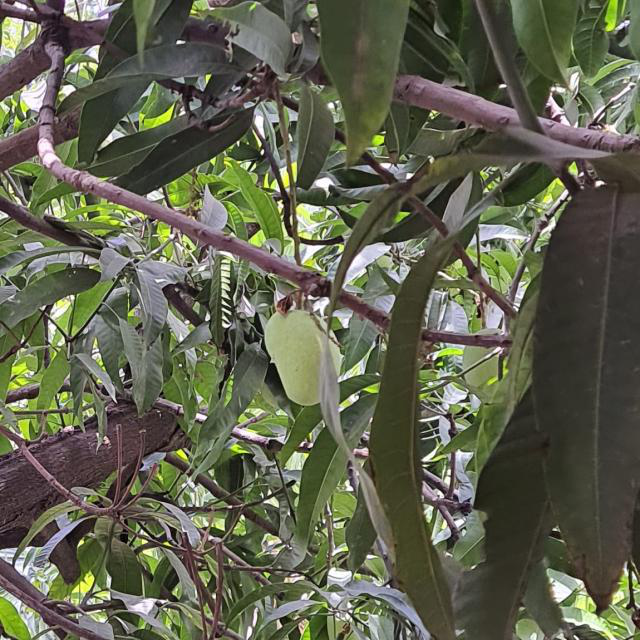

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

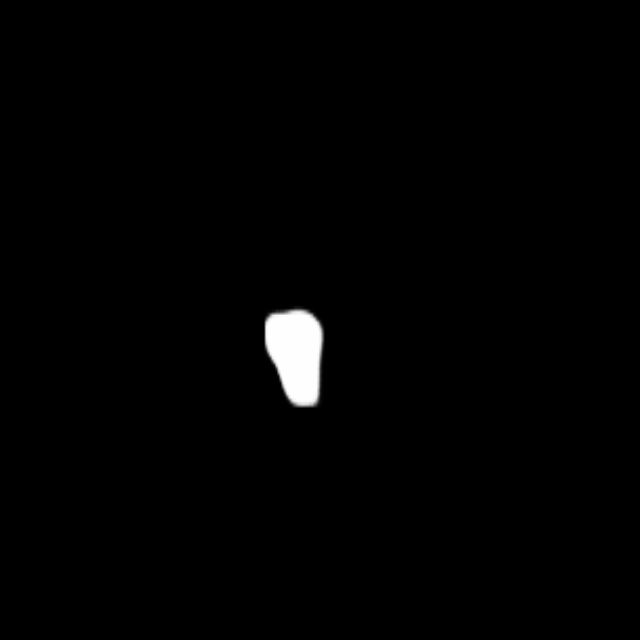

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
img.to(device).shape

torch.Size([3, 640, 640])

In [ ]:
import torch.onnx

model.eval()

# Let's create a dummy input tensor
dummy_input = torch.randn(1, 3, 640, 640, requires_grad=True)
# dummy_input = torch.randn
# Export the model
torch.onnx.export(model,         # model being run
      dummy_input,       # model input (or a tuple for multiple inputs)
      "ImageClassifier.onnx",       # where to save the model
      export_params=True,  # store the trained parameter weights inside the model file
      opset_version=10,    # the ONNX version to export the model to
      do_constant_folding=True,  # whether to execute constant folding for optimization
      input_names = ['modelInput'],   # the model's input names
      output_names = ['modelOutput'], # the model's output names
      dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes
                            'modelOutput' : {0 : 'batch_size'}})
print(" ")
print('Model has been converted to ONNX')

In [ ]:
torch.save(model.state_dict(), 'mango_mask01.pth')
from google.colab import files
# download checkpoint file
files.download('mango_mask01.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>